In [1]:
import numpy as np
from quantumreservoirpy.reservoirs import Static
from qiskit.quantum_info import random_unitary

In [2]:
encoder={
        0: '0',
        1: '1',  
    }
class RandomUnitary(Static):
    def __init__(self, n_qubits, memory=np.inf, backend=None) -> None:
        super().__init__(n_qubits, memory, backend)
        self.operator = random_unitary(2 ** n_qubits)
    
    def before(self, circuit):
        circuit.h(circuit.qubits)
    
    def during(self, circuit, timestep, reservoirnumber):
        circuit.measure(0)
        circuit.initialize(encoder[timestep], 0)
        circuit.append(self.operator, circuit.qubits)


In [3]:
n_qubits = 4
n_steps = 80
shots = 10000
target = [1, 0] * 30


In [4]:
res = RandomUnitary(n_qubits=n_qubits)
mean = res.run(target, shots=shots)
# res.circuit.draw('mpl')


/home/franzf/OpenQuantumComputing/quantumreservoirpy_vivaldi/quantumreservoirpy/reservoirbase.py:42: UserWarning: Argument 'backend' must inherit from qiskits abstract 'Backend'. Using 'aer_simulator' instead
  warnings.warn(
Running reservoirs: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:22<00:00, 22.97s/it]


(60, 1)


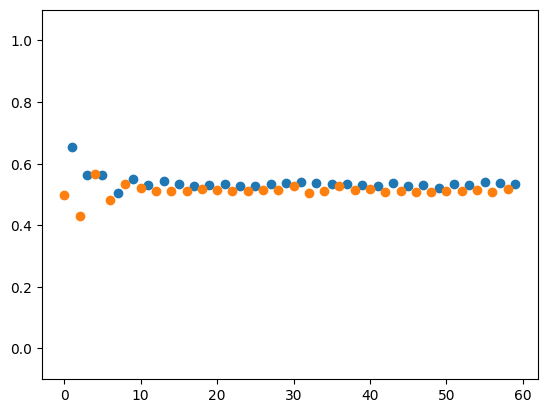

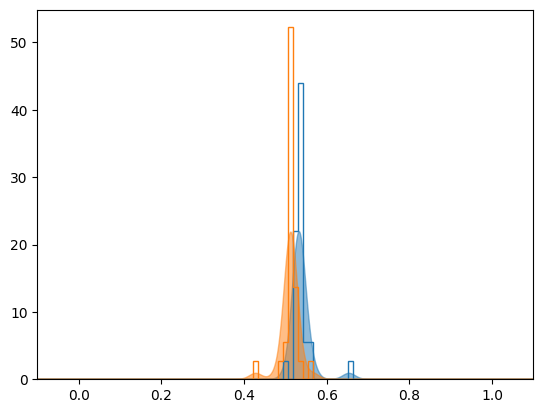

In [5]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
print(mean.shape)
plt.figure()
for t in np.unique(target):
    mask = t==target
    plt.plot(np.arange(len(mean))[mask], mean[mask], marker='o', lw=0)
plt.ylim(-0.1, 1.1)
plt.show()

x_plot = np.linspace(-0.5, 1.5, 10000, endpoint=True)

plt.figure()
for i, t in enumerate(np.unique(target)):
    color = 'C'+str(i)
    mask = t==target
    plt.hist(mean[mask], density=True, bins=np.linspace(-0.1, 1.1, 100, endpoint=True),
             histtype='step', color=color)
    kde = KernelDensity(bandwidth=1.5e-2, kernel='gaussian')
    kde.fit(mean[mask].reshape(-1, 1))
    logprob = kde.score_samples(x_plot.reshape(-1, 1))
    plt.fill_between(x_plot, np.exp(logprob), alpha=0.5, color=color)
    
plt.xlim(-0.1, 1.1)
plt.show()

In [6]:
x = mean.reshape(-1, 1)
y = target

warmup = 10
x = x[warmup:]
y = y[warmup:]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [7]:

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


clf = make_pipeline(StandardScaler(), SVC(gamma='auto', kernel='linear'))
clf.fit(X_train, y_train)

clf.score(X_test, y_test)

0.8823529411764706